In [ ]:
import pandas as pd
import requests
import json
import numpy as np
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

MODEL_ID = "gpt-3.5-turbo"
OPENAI_API_KEY = ""  


In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Using LLMs for Disease Prediction from Symptoms

In this notebook, we'll explore how to use Large Language Models (LLMs) to predict diseases based on symptoms using in-context learning techniques.

In [3]:
# Clean up the dataframe by removing spaces in symptom values
for col in df.columns:
    if 'Symptom_' in col:
        df[col] = df[col].str.strip() if df[col].dtype == 'object' else df[col]

# Count unique diseases
print(f"Total number of diseases: {df['Disease'].nunique()}")
print(f"Total number of samples: {len(df)}")

# Get the list of unique diseases for later use
unique_diseases = sorted(df['Disease'].unique())
print(f"First 5 diseases: {unique_diseases[:5]}")

Total number of diseases: 41
Total number of samples: 4920
First 5 diseases: ['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne', 'Alcoholic hepatitis', 'Allergy']


## Function to Query ChatGPT API

In [4]:
def query_chatgpt(prompt, model=MODEL_ID):
    """Function to query the ChatGPT API with a given prompt"""
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {OPENAI_API_KEY}"
    }
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }
    response = requests.post(url, headers=headers, json=data)
    response_json = response.json()
    
    # Debug: Print response for troubleshooting
    print("API Response:", response_json)
    
    # Check for errors in the API response
    if 'error' in response_json:
        error_message = response_json['error'].get('message', 'Unknown error')
        print(f"API Error: {error_message}")
        return {"choices": [{"message": {"content": f"ERROR: {error_message}"}}]}
    
    return response_json

In [5]:
def query_chatgpt_with_system(prompt, system_message, model=MODEL_ID):
    """Function to query the ChatGPT API with a system message and user prompt"""
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {OPENAI_API_KEY}"
    }
    data = {
        "model": model,
        "messages": [
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
    }
    response = requests.post(url, headers=headers, json=data)
    response_json = response.json()
    
    # Debug: Print response for troubleshooting
    print("API Response:", response_json)
    
    # Check for errors in the API response
    if 'error' in response_json:
        error_message = response_json['error'].get('message', 'Unknown error')
        print(f"API Error: {error_message}")
        return {"choices": [{"message": {"content": f"ERROR: {error_message}"}}]}
    
    return response_json

## Prepare Symptom Data for Processing

In [6]:
# Create a function to prepare symptoms list for each row
def get_symptoms_list(row):
    """Extract non-empty symptoms from a row and return as a list"""
    symptoms = []
    for i in range(1, 18):
        col = f'Symptom_{i}'
        if col in row and pd.notna(row[col]) and row[col] != '':
            symptoms.append(row[col])
    return symptoms

# Add a new column with symptom lists
df['Symptoms_List'] = df.apply(get_symptoms_list, axis=1)

# Display a sample
df[['Disease', 'Symptoms_List']].head()

,Disease,Symptoms_List
0,Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, dis..."
1,Fungal infection,"[skin_rash, nodal_skin_eruptions, dischromic _..."
2,Fungal infection,"[itching, nodal_skin_eruptions, dischromic _pa..."
3,Fungal infection,"[itching, skin_rash, dischromic _patches]"
4,Fungal infection,"[itching, skin_rash, nodal_skin_eruptions]"


## Split Data into Train and Test Sets

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Disease'])
print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 3936
Testing set size: 984


## Zero-shot Disease Prediction with Disease List

In [8]:
# Take a random sample from test set
sample = test_df.sample(1).iloc[0]
sample_symptoms = ", ".join(sample['Symptoms_List'])
actual_disease = sample['Disease']

# Create a formatted string of all unique diseases
diseases_list = ", ".join(unique_diseases)

prompt = f"""Based on the following symptoms, what disease might the patient have?

Symptoms: {sample_symptoms}

Choose from the following list of diseases:
{diseases_list}

Please respond with just the disease name from the list."""

response = query_chatgpt(prompt)
predicted_disease = response['choices'][0]['message']['content']

print(f"Symptoms: {sample_symptoms}")
print(f"Actual disease: {actual_disease}")
print(f"Predicted disease: {predicted_disease}")

API Response: {'id': 'chatcmpl-BJFASZtVbC03IdLhgrawff2Z5qMF0', 'object': 'chat.completion', 'created': 1743926236, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Varicose veins', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 257, 'completion_tokens': 5, 'total_tokens': 262, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
Symptoms: fatigue, cramps, bruising, obesity, swollen_legs, swollen_blood_vessels, prominent_veins_on_calf
Actual disease: Varicose veins
Predicted disease: Varicose veins


## Using System Role for Medical Context with Disease List

In [9]:
# Take another random sample
sample = test_df.sample(1).iloc[0]
sample_symptoms = ", ".join(sample['Symptoms_List'])
actual_disease = sample['Disease']

system_message = "You are a medical diagnostic assistant with expertise in identifying diseases based on symptoms. Respond with only the most likely disease name from the provided list of diseases."

# Create a formatted string of all unique diseases
diseases_list = ", ".join(unique_diseases)

prompt = f"""Based on these symptoms, what disease might the patient have?

Symptoms: {sample_symptoms}

Choose from the following list of diseases:
{diseases_list}

Respond with only the disease name from the list."""

response = query_chatgpt_with_system(prompt, system_message)
predicted_disease = response['choices'][0]['message']['content']

print(f"Symptoms: {sample_symptoms}")
print(f"Actual disease: {actual_disease}")
print(f"Predicted disease: {predicted_disease}")

API Response: {'id': 'chatcmpl-BJFAS4pp6P6eSbHtmQC1lIEVbCxeD', 'object': 'chat.completion', 'created': 1743926236, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Arthritis', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 282, 'completion_tokens': 3, 'total_tokens': 285, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
Symptoms: joint_pain, neck_pain, knee_pain, hip_joint_pain, painful_walking
Actual disease: Osteoarthristis
Predicted disease: Arthritis


## Few-shot In-Context Learning for Disease Prediction with Disease List

In [10]:
def generate_few_shot_examples(train_df, n_examples=3):
    """Generate few-shot examples from the training data"""
    # Get a representative sample of diseases from the training set
    unique_diseases = train_df['Disease'].unique()
    selected_diseases = np.random.choice(unique_diseases, min(n_examples, len(unique_diseases)), replace=False)
    
    examples = []
    
    for disease in selected_diseases:
        # Get samples for this disease
        disease_samples = train_df[train_df['Disease'] == disease]
        # Select a random sample
        sample = disease_samples.sample(1).iloc[0]
        symptoms = ", ".join(sample['Symptoms_List'])
        example = f"Symptoms: {symptoms}\nDisease: {disease}\n"
        examples.append(example)
    
    return "\n".join(examples)

In [11]:
# Test the few-shot in-context learning approach
sample = test_df.sample(1).iloc[0]
sample_symptoms = ", ".join(sample['Symptoms_List'])
actual_disease = sample['Disease']

# Generate few-shot examples
few_shot_examples = generate_few_shot_examples(train_df, n_examples=5)

# Create a formatted string of all unique diseases
diseases_list = ", ".join(unique_diseases)

system_message = "You are a medical diagnostic assistant with expertise in identifying diseases based on symptoms. Analyze the examples and then diagnose the new case by selecting a disease from the provided list."

prompt = f"""Here are some examples of symptoms and their corresponding diseases:

{few_shot_examples}

Now, based on these new symptoms, what disease might the patient have?

Symptoms: {sample_symptoms}

Choose from the following list of diseases:
{diseases_list}

Respond with only the most likely disease name from the list without any other text."""

response = query_chatgpt_with_system(prompt, system_message)
predicted_disease = response['choices'][0]['message']['content']

print(f"Symptoms: {sample_symptoms}")
print(f"Actual disease: {actual_disease}")
print(f"Predicted disease: {predicted_disease}")

API Response: {'id': 'chatcmpl-BJFATX0kibqPJPfOpcgqeWAYldj9v', 'object': 'chat.completion', 'created': 1743926237, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Alcoholic hepatitis', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 533, 'completion_tokens': 4, 'total_tokens': 537, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
Symptoms: joint_pain, vomiting, fatigue, high_fever, yellowish_skin, dark_urine, nausea, loss_of_appetite, abdominal_pain, yellowing_of_eyes, acute_liver_failure, coma, stomach_bleeding
Actual disease: Hepatitis E
Predicted disease: Alcoholic hepatitis


## Evaluation on Test Set

In [12]:
def evaluate_model(test_samples, train_df, unique_diseases, n_examples=5):
    """Evaluate the model on a set of test samples"""
    predictions = []
    actuals = []
    
    # Generate few-shot examples once
    few_shot_examples = generate_few_shot_examples(train_df, n_examples=n_examples)
    
    # Create a formatted string of all unique diseases
    diseases_list = ", ".join(unique_diseases)
    
    system_message = "You are a medical diagnostic assistant with expertise in identifying diseases based on symptoms. Analyze the examples and then diagnose the new case by selecting a disease from the provided list."
    
    for _, sample in tqdm(test_samples.iterrows(), total=len(test_samples)):
        sample_symptoms = ", ".join(sample['Symptoms_List'])
        actual_disease = sample['Disease']
        
        prompt = f"""Here are some examples of symptoms and their corresponding diseases:

{few_shot_examples}

Now, based on these new symptoms, what disease might the patient have?

Symptoms: {sample_symptoms}

Choose from the following list of diseases:
{diseases_list}

Respond with only the most likely disease name from the list and nothing else."""
        
        try:
            response = query_chatgpt_with_system(prompt, system_message)
            predicted_disease = response['choices'][0]['message']['content']
            predictions.append(predicted_disease.strip())
            actuals.append(actual_disease)
            
            # Add a delay to avoid API rate limits
            time.sleep(20)
        except Exception as e:
            print(f"Error: {e}")
            predictions.append("ERROR")
            actuals.append(actual_disease)
    
    # Clean predictions to match disease names
    cleaned_predictions = []
    for pred in predictions:
        # Simple cleanup: just keep the first sentence
        pred = pred.split(".")[0]
        # Remove common prefixes
        for prefix in ["The disease is", "The patient has", "This patient has", "Disease:"]:
            if pred.lower().startswith(prefix.lower()):
                pred = pred[len(prefix):].strip()
        cleaned_predictions.append(pred)
    
    return cleaned_predictions, actuals

In [13]:
# Take a small subset of test data to evaluate (to avoid high API costs)
test_subset = test_df.sample(10, random_state=42)

# Evaluate the model
predictions, actuals = evaluate_model(test_subset, train_df, unique_diseases, n_examples=5)

# Calculate accuracy
exact_matches = sum(p.lower() == a.lower() for p, a in zip(predictions, actuals))
accuracy = exact_matches / len(actuals)

print(f"Accuracy: {accuracy:.2f}")

# Show detailed results
results_df = pd.DataFrame({
    'Actual Disease': actuals,
    'Predicted Disease': predictions,
    'Correct': [p.lower() == a.lower() for p, a in zip(predictions, actuals)]
})

results_df

  0%|          | 0/10 [00:00<?, ?it/s]

API Response: {'id': 'chatcmpl-BJFAU65jT3xQeX3MW6yCE7af6kWZM', 'object': 'chat.completion', 'created': 1743926238, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Common Cold', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 484, 'completion_tokens': 3, 'total_tokens': 487, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 10%|█         | 1/10 [00:20<03:04, 20.50s/it]

API Response: {'id': 'chatcmpl-BJFApEk20vcFkF5TWgxc1aClREQic', 'object': 'chat.completion', 'created': 1743926259, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Varicose veins', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 492, 'completion_tokens': 5, 'total_tokens': 497, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 20%|██        | 2/10 [00:41<02:46, 20.82s/it]

API Response: {'id': 'chatcmpl-BJFB9YaeVcAWJe5ckQBSy7k3OZGgF', 'object': 'chat.completion', 'created': 1743926279, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Psoriasis', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 495, 'completion_tokens': 3, 'total_tokens': 498, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 30%|███       | 3/10 [01:02<02:24, 20.70s/it]

API Response: {'id': 'chatcmpl-BJFBUjAzHs1aZYKV8yJH2sFzj1UFh', 'object': 'chat.completion', 'created': 1743926300, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Arthritis', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 492, 'completion_tokens': 3, 'total_tokens': 495, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 40%|████      | 4/10 [01:23<02:04, 20.82s/it]

API Response: {'id': 'chatcmpl-BJFBpba4Sfsb5L4xVFdb25ez7kyEi', 'object': 'chat.completion', 'created': 1743926321, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Hepatitis B', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 519, 'completion_tokens': 5, 'total_tokens': 524, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 50%|█████     | 5/10 [01:43<01:44, 20.81s/it]

API Response: {'id': 'chatcmpl-BJFCA9B5ocxfvI6FWrEVCxzCl1yEU', 'object': 'chat.completion', 'created': 1743926342, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Migraine', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 500, 'completion_tokens': 4, 'total_tokens': 504, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 60%|██████    | 6/10 [02:04<01:22, 20.74s/it]

API Response: {'id': 'chatcmpl-BJFCVCJ5SAb5nHJLwm1sN22sQMJLM', 'object': 'chat.completion', 'created': 1743926363, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Stroke', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 481, 'completion_tokens': 2, 'total_tokens': 483, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 70%|███████   | 7/10 [02:25<01:02, 20.71s/it]

API Response: {'id': 'chatcmpl-BJFCpbeySdGgkyWHnYkvTgnifvd1h', 'object': 'chat.completion', 'created': 1743926383, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Dengue', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 518, 'completion_tokens': 4, 'total_tokens': 522, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 80%|████████  | 8/10 [02:46<00:41, 20.77s/it]

API Response: {'id': 'chatcmpl-BJFDBfCRdSmGoJPNqO8lF0KxJTUCp', 'object': 'chat.completion', 'created': 1743926405, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Tuberculosis', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 527, 'completion_tokens': 4, 'total_tokens': 531, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 90%|█████████ | 9/10 [03:07<00:21, 21.06s/it]

API Response: {'id': 'chatcmpl-BJFDWNbjKZNB7xUqobbTAKK8nG46L', 'object': 'chat.completion', 'created': 1743926426, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Urinary tract infection', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 490, 'completion_tokens': 5, 'total_tokens': 495, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


100%|██████████| 10/10 [03:28<00:00, 20.84s/it]

Accuracy: 0.70


,Actual Disease,Predicted Disease,Correct
0,Allergy,Common Cold,False
1,Varicose veins,Varicose veins,True
2,Psoriasis,Psoriasis,True
3,Osteoarthristis,Arthritis,False
4,Hepatitis B,Hepatitis B,True
5,Migraine,Migraine,True
6,Paralysis (brain hemorrhage),Stroke,False
7,Dengue,Dengue,True
8,Tuberculosis,Tuberculosis,True
9,Urinary tract infection,Urinary tract infection,True


## Chain of Thought (CoT) Reasoning for Disease Prediction

In [14]:
# Implement Chain of Thought reasoning to explain the disease diagnosis process
sample = test_df.sample(1).iloc[0]
sample_symptoms = ", ".join(sample['Symptoms_List'])
actual_disease = sample['Disease']

# Create a formatted string of all unique diseases
diseases_list = ", ".join(unique_diseases)

system_message = """You are a medical diagnostic assistant with expertise in identifying diseases based on symptoms.
First, think through each symptom step by step and consider what diseases might cause these symptoms.
Then, examine how these symptoms interact with each other and narrow down to the most likely disease from the provided list."""

prompt = f"""Given these symptoms, I want you to think step by step about what disease the patient might have.

Symptoms: {sample_symptoms}

1. First, analyze each symptom individually and note what diseases it could indicate.
2. Then, consider how these symptoms relate to each other.
3. Based on the symptom combination, narrow down the possible diseases.
4. Finally, select the most likely disease from this list:
{diseases_list}

After your analysis, conclude with "The most likely disease is: [DISEASE NAME]" - using only a disease name from the provided list."""

response = query_chatgpt_with_system(prompt, system_message)
cot_analysis = response['choices'][0]['message']['content']

# Extract the final diagnosis from the CoT reasoning
import re
final_diagnosis_match = re.search(r"The most likely disease is:?\s*([A-Za-z\s]+)", cot_analysis)
if final_diagnosis_match:
    predicted_disease = final_diagnosis_match.group(1).strip()
else:
    predicted_disease = "Could not determine"

print(f"Symptoms: {sample_symptoms}")
print(f"Actual disease: {actual_disease}")
print("\nChain of Thought Analysis:")
print(cot_analysis)


API Response: {'id': 'chatcmpl-BJFDqDM6QexlWHFrhXGXkv1qWAvME', 'object': 'chat.completion', 'created': 1743926446, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '1. **Continuous Sneezing:** This symptom is commonly associated with allergies, common cold, or sinus infection.\n\n2. **Shivering and Chills:** Shivering and chills can be indicative of a systemic infection like flu, malaria, dengue, or pneumonia.\n\n3. **Watering from Eyes:** This symptom is often seen in cases of allergies, sinusitis, or viral infections like the common cold.\n\n4. **Analysis of Symptoms Interaction:** The combination of continuous sneezing, shivering, chills, and watering from eyes suggests a systemic viral or bacterial infection, likely involving the respiratory system and possibly the sinuses.\n\n5. **Narrowing Down Possible Diseases:** Given the symptoms presented and their interaction, the most likely diseases from the provided list are common cold,

## Tree of Thought (ToT) Reasoning for Disease Prediction

In [15]:
def explore_diagnostic_branch(symptoms, branch_diseases, depth=0, max_branches=3):
    """Explore a specific diagnostic branch in the Tree of Thought approach"""
    if len(branch_diseases) <= 1 or depth >= 2:  # Stop condition
        return branch_diseases[0] if branch_diseases else "Unknown"
    
    system_message = "You are a medical diagnostic assistant using Tree of Thought reasoning to narrow down disease possibilities."
    
    # Select top N diseases to explore as branches
    selected_diseases = branch_diseases[:min(max_branches, len(branch_diseases))]
    other_diseases = branch_diseases[min(max_branches, len(branch_diseases)):]
    
    diseases_to_explore = ", ".join(selected_diseases)
    
    prompt = f"""Given the symptoms: {symptoms}
    
I'm considering these possible diseases: {diseases_to_explore}

For each disease, evaluate how well it matches the symptoms and rank them from most likely to least likely.
1. Consider what symptoms would be expected for each disease
2. Compare with the actual symptoms provided
3. Consider what symptoms might be missing
4. Rank the diseases from most likely to least likely

Format your response as:
RANKING:
1. [Disease 1]
2. [Disease 2]
3. [Disease 3]
"""
    
    response = query_chatgpt_with_system(prompt, system_message)
    analysis = response['choices'][0]['message']['content']
    
    print(f"\nBranch Exploration (Depth {depth}):")
    print(analysis)
    
    # Extract ranking
    ranking_match = re.search(r"RANKING:\s*1\.\s*([A-Za-z\s]+)", analysis)
    if ranking_match:
        top_disease = ranking_match.group(1).strip()
        return top_disease
    else:
        return selected_diseases[0] if selected_diseases else "Unknown"

In [16]:
# Implement Tree of Thought reasoning for disease diagnosis
sample = test_df.sample(1).iloc[0]
sample_symptoms = ", ".join(sample['Symptoms_List'])
actual_disease = sample['Disease']

# Initial filtering of diseases based on symptoms
system_message = "You are a medical diagnostic assistant tasked with identifying potential diseases from symptoms."

prompt = f"""Given these symptoms: {sample_symptoms}

List the 10 most likely diseases from this list, ordered from most likely to least likely:
{', '.join(unique_diseases)}

Format your response as:
POTENTIAL DISEASES:
1. [Disease 1]
2. [Disease 2]
...and so on
"""

response = query_chatgpt_with_system(prompt, system_message)
initial_analysis = response['choices'][0]['message']['content']

print("Initial Disease Candidates:")
print(initial_analysis)

# Extract the potential diseases from the response
potential_diseases = []
for line in initial_analysis.split('\n'):
    match = re.search(r'^\d+\.\s*([A-Za-z\s]+)', line)
    if match:
        potential_diseases.append(match.group(1).strip())

# Explore the tree of diagnostic possibilities
if potential_diseases:
    tot_prediction = explore_diagnostic_branch(sample_symptoms, potential_diseases)
else:
    # Fallback if no potential diseases were found
    tot_prediction = "Could not determine"

print(f"\nSymptoms: {sample_symptoms}")
print(f"Actual disease: {actual_disease}")
print(f"Tree of Thought prediction: {tot_prediction}")

API Response: {'id': 'chatcmpl-BJFDsfH6Zkf9xHvmWOwJQWMyQYryG', 'object': 'chat.completion', 'created': 1743926448, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'POTENTIAL DISEASES:\n1. Psoriasis\n2. Fungal infection\n3. Arthritis\n4. Impetigo\n5. Acne\n6. Allergy\n7. Drug Reaction\n8. Dengue\n9. Chicken pox\n10. Hepatitis B', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 297, 'completion_tokens': 62, 'total_tokens': 359, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
Initial Disease Candidates:
POTENTIAL DISEASES:
1. Psoriasis
2. Fungal infection
3. Arthritis
4. Impetigo
5. Acne
6. Allergy
7. Drug Reaction
8. Dengue
9. Chicken pox
10. Hepatitis B
API Response:

In [17]:
def evaluate_tot_model(test_samples, unique_diseases, n_samples=5):
    """Evaluate the Tree of Thought model on test samples"""
    predictions = []
    actuals = []
    
    # Take a subset to avoid excessive API calls
    if len(test_samples) > n_samples:
        test_subset = test_samples.sample(n_samples, random_state=42)
    else:
        test_subset = test_samples
    
    for _, sample in tqdm(test_subset.iterrows(), total=len(test_subset)):
        sample_symptoms = ", ".join(sample['Symptoms_List'])
        actual_disease = sample['Disease']
        
        # Initial filtering of diseases
        system_message = "You are a medical diagnostic assistant identifying potential diseases from symptoms."
        
        prompt = f"""Given these symptoms: {sample_symptoms}

List the 7 most likely diseases from this list, ordered from most likely to least likely:
{', '.join(unique_diseases)}

Format your response as:
POTENTIAL DISEASES:
1. [Disease 1]
2. [Disease 2]
...and so on
"""
        
        try:
            response = query_chatgpt_with_system(prompt, system_message)
            initial_analysis = response['choices'][0]['message']['content']
            
            # Extract potential diseases
            potential_diseases = []
            for line in initial_analysis.split('\n'):
                match = re.search(r'^\d+\.\s*([A-Za-z\s]+)', line)
                if match:
                    potential_diseases.append(match.group(1).strip())
            
            # Explore branches
            if potential_diseases:
                tot_prediction = explore_diagnostic_branch(sample_symptoms, potential_diseases)
            else:
                tot_prediction = "Could not determine"
            
            predictions.append(tot_prediction)
            actuals.append(actual_disease)
            
            # Wait to avoid rate limits
            time.sleep(2)
            
        except Exception as e:
            print(f"Error: {e}")
            predictions.append("ERROR")
            actuals.append(actual_disease)
    
    return predictions, actuals

In [18]:
# Compare the different reasoning approaches on a small test set
test_subset = test_df.sample(6, random_state=45)

# Standard approach (from earlier code)
print("Evaluating standard approach...")
standard_predictions, standard_actuals = evaluate_model(test_subset, train_df, unique_diseases, n_examples=6)

# ToT approach
print("\nEvaluating Tree of Thought approach...")
tot_predictions, tot_actuals = evaluate_tot_model(test_subset, unique_diseases, n_samples=6)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Symptoms': [", ".join(sample['Symptoms_List']) for _, sample in test_subset.iterrows()],
    'Actual Disease': standard_actuals,
    'Standard Prediction': standard_predictions,
    'ToT Prediction': tot_predictions,
    'Standard Correct': [p.lower() == a.lower() for p, a in zip(standard_predictions, standard_actuals)],
    'ToT Correct': [p.lower() == a.lower() for p, a in zip(tot_predictions, tot_actuals)]
})

print("\nComparison of methods:")
print(comparison_df[['Actual Disease', 'Standard Prediction', 'ToT Prediction', 'Standard Correct', 'ToT Correct']])

# Calculate accuracy for each method
standard_accuracy = sum(comparison_df['Standard Correct']) / len(comparison_df)
tot_accuracy = sum(comparison_df['ToT Correct']) / len(comparison_df)

print(f"\nStandard approach accuracy: {standard_accuracy:.2f}")
print(f"Tree of Thought approach accuracy: {tot_accuracy:.2f}")

if tot_accuracy > standard_accuracy:
    print("\nThe Tree of Thought approach performed better on this test set.")
elif standard_accuracy > tot_accuracy:
    print("\nThe standard approach performed better on this test set.")
else:
    print("\nBoth approaches performed equally on this test set.")

Evaluating standard approach...


  0%|          | 0/6 [00:00<?, ?it/s]

API Response: {'id': 'chatcmpl-BJFDxaUspjB5vxDsrEuThFxdq7EYv', 'object': 'chat.completion', 'created': 1743926453, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Hypothyroidism', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 582, 'completion_tokens': 6, 'total_tokens': 588, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 17%|█▋        | 1/6 [00:20<01:43, 20.63s/it]

API Response: {'id': 'chatcmpl-BJFEH1PLUmh2vhhahXeoBQUYDw88k', 'object': 'chat.completion', 'created': 1743926473, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Chronic cholestasis', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 557, 'completion_tokens': 6, 'total_tokens': 563, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 33%|███▎      | 2/6 [00:41<01:22, 20.65s/it]

API Response: {'id': 'chatcmpl-BJFEdEL0HYhEYWcKA7yvu8buzCNIh', 'object': 'chat.completion', 'created': 1743926495, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Stroke', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 543, 'completion_tokens': 2, 'total_tokens': 545, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 50%|█████     | 3/6 [01:02<01:02, 20.91s/it]

API Response: {'id': 'chatcmpl-BJFEyPriBDLL2HkJt6L3cgApKSPOu', 'object': 'chat.completion', 'created': 1743926516, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Hyperthyroidism', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 582, 'completion_tokens': 5, 'total_tokens': 587, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 67%|██████▋   | 4/6 [01:23<00:41, 20.98s/it]

API Response: {'id': 'chatcmpl-BJFFIY5tlBMOGFUh6rrK8cKiLRduz', 'object': 'chat.completion', 'created': 1743926536, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Tuberculosis', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 589, 'completion_tokens': 4, 'total_tokens': 593, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


 83%|████████▎ | 5/6 [01:44<00:20, 20.85s/it]

API Response: {'id': 'chatcmpl-BJFFdPBA4o4ZjQHjmyiamHpKNHO8o', 'object': 'chat.completion', 'created': 1743926557, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Chicken pox', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 568, 'completion_tokens': 4, 'total_tokens': 572, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}


100%|██████████| 6/6 [02:05<00:00, 20.86s/it]



Evaluating Tree of Thought approach...


  0%|          | 0/6 [00:00<?, ?it/s]

API Response: {'id': 'chatcmpl-BJFFyuRgK52oQfDBhrnilYqaTCmw7', 'object': 'chat.completion', 'created': 1743926578, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'POTENTIAL DISEASES:\n1. Hyperthyroidism\n2. Hypothyroidism\n3. Hypertension\n4. Diabetes\n5. Hypoglycemia\n6. Depression\n7. Abnormal Menstruation', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 320, 'completion_tokens': 52, 'total_tokens': 372, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
API Response: {'id': 'chatcmpl-BJFFzJuI2yYVtyyWKutruiwngiZZy', 'object': 'chat.completion', 'created': 1743926579, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content':

 17%|█▋        | 1/6 [00:05<00:27,  5.50s/it]

API Response: {'id': 'chatcmpl-BJFG3TKxheYu11qiJMyOvsePls5XQ', 'object': 'chat.completion', 'created': 1743926583, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'POTENTIAL DISEASES:\n1. Chronic cholestasis\n2. Hypothyroidism\n3. Hyperthyroidism\n4. Hypertension\n5. Varicose veins\n6. Obesity-related complications (e.g., heart attack, diabetes)\n7. Hepatitis B', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 295, 'completion_tokens': 62, 'total_tokens': 357, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
API Response: {'id': 'chatcmpl-BJFG4XbF59bfvMZdtsFtr5u6xTltE', 'object': 'chat.completion', 'created': 1743926584, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'i

 33%|███▎      | 2/6 [00:12<00:24,  6.12s/it]

API Response: {'id': 'chatcmpl-BJFGAG41LUpumGXYhmctNCZNREiAT', 'object': 'chat.completion', 'created': 1743926590, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'POTENTIAL DISEASES:\n1. Migraine\n2. Stroke (Paralysis - brain hemorrhage)\n3. Drug Reaction\n4. Hypoglycemia\n5. Alcoholic hepatitis\n6. Hyperthyroidism\n7. Meningitis', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 281, 'completion_tokens': 57, 'total_tokens': 338, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
API Response: {'id': 'chatcmpl-BJFGBy1enU7yMNyPRZsBc5jog6Yrz', 'object': 'chat.completion', 'created': 1743926591, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': '

 50%|█████     | 3/6 [00:17<00:16,  5.59s/it]

API Response: {'id': 'chatcmpl-BJFGFfgVFpm5JPjHZnYjNv6YuJhD0', 'object': 'chat.completion', 'created': 1743926595, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'POTENTIAL DISEASES:\n1. Hyperthyroidism\n2. Hypothyroidism\n3. Depression\n4. Hypoglycemia\n5. Diabetes\n6. Hypertension\n7. Abnormal menstruation', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 320, 'completion_tokens': 51, 'total_tokens': 371, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
API Response: {'id': 'chatcmpl-BJFGGAedm1OHIzxRcNsMM9hMT2i0c', 'object': 'chat.completion', 'created': 1743926596, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content':

 67%|██████▋   | 4/6 [00:22<00:11,  5.51s/it]

API Response: {'id': 'chatcmpl-BJFGKGfEA3W8sAwNsaCqw3Lb952ol', 'object': 'chat.completion', 'created': 1743926600, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'POTENTIAL DISEASES:\n1. Pneumonia\n2. Tuberculosis\n3. Common Cold\n4. Bronchial Asthma\n5. Hepatitis B\n6. Dengue\n7. Gastroenteritis', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 327, 'completion_tokens': 51, 'total_tokens': 378, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
API Response: {'id': 'chatcmpl-BJFGLcY6EghFsNx5bv9uHaPHkhpJe', 'object': 'chat.completion', 'created': 1743926601, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'RANKING:\n

 83%|████████▎ | 5/6 [00:28<00:05,  5.61s/it]

API Response: {'id': 'chatcmpl-BJFGQpvLn2N4p2T4z4BBAP79LwwIP', 'object': 'chat.completion', 'created': 1743926606, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'POTENTIAL DISEASES:\n1. Chicken pox\n2. Dengue\n3. Common Cold\n4. Measles\n5. Malaria\n6. Acute Hepatitis B\n7. Allergy', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 306, 'completion_tokens': 48, 'total_tokens': 354, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
API Response: {'id': 'chatcmpl-BJFGRx06iNZf6vRyqlUkBGZet2cER', 'object': 'chat.completion', 'created': 1743926607, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'RANKING:\n1. Chicken Pox

100%|██████████| 6/6 [00:32<00:00,  5.49s/it]


Comparison of methods:
                 Actual Disease  Standard Prediction       ToT Prediction  \
0                Hypothyroidism       Hypothyroidism       Hypothyroidism   
1                Varicose veins  Chronic cholestasis  Chronic cholestasis   
2  Paralysis (brain hemorrhage)               Stroke               Stroke   
3                Hypothyroidism      Hyperthyroidism       Hypothyroidism   
4                  Tuberculosis         Tuberculosis         Tuberculosis   
5                   Chicken pox          Chicken pox          Chicken Pox   

   Standard Correct  ToT Correct  
0              True         True  
1             False        False  
2             False        False  
3             False         True  
4              True         True  
5              True         True  

Standard approach accuracy: 0.50
Tree of Thought approach accuracy: 0.67

The Tree of Thought approach performed better on this test set.


## Comparison of Reasoning Approaches

We've implemented three different reasoning approaches for disease prediction:

1. **Standard Approach**: Directly asking the model to predict a disease from symptoms
2. **Chain of Thought (CoT)**: Having the model think step-by-step through the symptoms before making a prediction
3. **Tree of Thought (ToT)**: Exploring multiple diagnostic branches by first identifying candidate diseases, then refining through analysis of each branch

The ToT approach mimics how medical professionals diagnose diseases - first creating a differential diagnosis (list of possibilities), then narrowing down through additional reasoning. This approach may improve accuracy by:

1. Reducing premature commitment to a single diagnosis
2. Exploring more alternatives systematically
3. Providing more structured reasoning before making a final decision

The comparative evaluation helps identify which approach works best for this specific disease prediction task.

# Combining Advanced Reasoning and In-Context Learning for Healthcare Applications

In this section, we'll explore how to combine different reasoning approaches (Chain of Thought, Tree of Thought) with in-context learning to improve performance on various downstream tasks like disease prediction, symptom classification, and severity assessment.

In [19]:
# Let's categorize diseases by type to enable more nuanced predictions
import pandas as pd
from collections import defaultdict

# Create a simple disease categorization based on common medical categories
disease_categories = {
    'Infectious': ['Fungal infection', 'Hepatitis', 'Malaria', 'Tuberculosis', 'Typhoid', 'Chicken pox', 
                  'Dengue', 'Common Cold', 'Pneumonia', 'Dimorphic hemorrhoids(piles)'],
    'Digestive': ['Peptic ulcer diseae', 'GERD', 'Chronic cholestasis', 'Gastroenteritis', 'Jaundice',
                 'Hepatitis', 'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E', 'Alcoholic hepatitis', 
                 'Irritable bowel syndrome', 'Impetigo'],
    'Respiratory': ['Bronchial Asthma', 'Pneumonia', 'Tuberculosis', 'Common Cold', 'Pneumonia'], 
    'Cardiovascular': ['Hypertension', 'Heart attack', 'Varicose veins', 'Hypothyroidism', 'Hypoglycemia'],
    'Skin': ['Acne', 'Psoriasis', 'Impetigo', 'Fungal infection'],
    'Neurological': ['Migraine', 'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Osteoarthristis', 
                    'Vertigo', '(vertigo) Paroymsal  Positional Vertigo'],
    'Metabolic': ['Diabetes', 'Hyperthyroidism', 'Hypothyroidism', 'Hypoglycemia', 'Osteoarthristis'],
    'Other': []  # Catch-all for diseases not in other categories
}

# Create a reverse mapping from disease to category
disease_to_category = {}
for category, diseases in disease_categories.items():
    for disease in diseases:
        disease_to_category[disease] = category

# Add any diseases from our dataset that aren't categorized to "Other"
for disease in unique_diseases:
    if disease not in disease_to_category:
        disease_to_category[disease] = 'Other'
        disease_categories['Other'].append(disease)

# Display the first few diseases and their categories
print("Sample disease categorizations:")
for i, (disease, category) in enumerate(list(disease_to_category.items())[:10]):
    print(f"{disease}: {category}")

# Count diseases by category
category_counts = defaultdict(int)
for disease in unique_diseases:
    category = disease_to_category.get(disease, 'Other')
    category_counts[category] += 1

print("\nDisease counts by category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

Sample disease categorizations:
Fungal infection: Skin
Hepatitis: Digestive
Malaria: Infectious
Tuberculosis: Respiratory
Typhoid: Infectious
Chicken pox: Infectious
Dengue: Infectious
Common Cold: Respiratory
Pneumonia: Respiratory
Dimorphic hemorrhoids(piles): Infectious

Disease counts by category:
Neurological: 4
Other: 9
Skin: 4
Digestive: 10
Respiratory: 4
Infectious: 4
Cardiovascular: 2
Metabolic: 4


## Hierarchical Disease Prediction with Multi-Stage Reasoning

In clinical practice, doctors often use a hierarchical approach to diagnosis:
1. First, they determine the general system affected (e.g., respiratory, digestive)
2. Then they narrow down to specific diseases within that system

Let's implement this approach using a two-stage hierarchical prediction model:

In [20]:
def hierarchical_disease_prediction(symptoms, unique_diseases, disease_to_category, disease_categories):
    """Perform hierarchical prediction using a two-stage approach"""
    # Stage 1: Predict the disease category
    system_message_stage1 = "You are a medical expert tasked with determining which body system is primarily affected based on symptoms."
    
    category_list = ", ".join(sorted(set(disease_to_category.values())))
    
    prompt_stage1 = f"""Based on these symptoms, which body system or disease category is most likely affected?

Symptoms: {symptoms}

Categories to choose from: {category_list}

Analyze each symptom carefully and think about which body system they primarily affect.
Respond with only the category name from the list."""
    
    # Get the predicted category
    response_stage1 = query_chatgpt_with_system(prompt_stage1, system_message_stage1)
    predicted_category = response_stage1['choices'][0]['message']['content'].strip()
    
    # Default to most common category if prediction doesn't match any category
    if predicted_category not in disease_categories:
        # Find closest match or use most populous category
        categories = list(disease_categories.keys())
        # Simple fallback - use the category with most diseases
        predicted_category = max(categories, key=lambda c: len(disease_categories[c]))
    
    print(f"Stage 1 - Predicted category: {predicted_category}")
    
    # Stage 2: Predict specific disease within the category
    # Get diseases in the predicted category
    diseases_in_category = disease_categories[predicted_category]
    
    # Add a few diseases from other categories to avoid artificially constraining the model
    other_diseases = []
    for category, diseases in disease_categories.items():
        if category != predicted_category:
            other_diseases.extend(diseases[:2])  # Add a couple from each other category
    
    # Combine the diseases, ensuring we don't have duplicates
    relevant_diseases = list(set(diseases_in_category + other_diseases))
    diseases_prompt = ", ".join(relevant_diseases)
    
    system_message_stage2 = "You are a medical diagnostic specialist focusing on specific diseases within a body system."
    
    prompt_stage2 = f"""Based on these symptoms, what specific disease is the patient most likely suffering from?

Symptoms: {symptoms}

We've determined the symptoms likely affect the {predicted_category} system.
Choose from these diseases: {diseases_prompt}

Think step by step:
1. Consider which symptoms are most characteristic of diseases in this category
2. Match the symptom pattern to specific diseases
3. Identify the most likely disease based on the complete symptom profile

Respond with only the disease name."""
    
    # Get the predicted disease
    response_stage2 = query_chatgpt_with_system(prompt_stage2, system_message_stage2)
    predicted_disease = response_stage2['choices'][0]['message']['content'].strip()
    
    return predicted_category, predicted_disease

In [21]:
# Test the hierarchical prediction approach
sample = test_df.sample(1).iloc[0]
sample_symptoms = ", ".join(sample['Symptoms_List'])
actual_disease = sample['Disease']
actual_category = disease_to_category.get(actual_disease, 'Other')

print(f"Symptoms: {sample_symptoms}")
print(f"Actual disease: {actual_disease} (Category: {actual_category})")

predicted_category, predicted_disease = hierarchical_disease_prediction(
    sample_symptoms, unique_diseases, disease_to_category, disease_categories
)

print(f"\nPredicted category: {predicted_category}")
print(f"Predicted disease: {predicted_disease}")

# Compare with direct prediction (without hierarchy)
system_message = "You are a medical diagnostic assistant."
prompt = f"""Based on these symptoms, what disease might the patient have?

Symptoms: {sample_symptoms}

Choose from the following list of diseases:
{', '.join(unique_diseases)}

Respond with only the disease name from the list."""

response = query_chatgpt_with_system(prompt, system_message)
direct_prediction = response['choices'][0]['message']['content'].strip()

print(f"\nDirect prediction (without hierarchy): {direct_prediction}")

print(f"\nAccuracy comparison:")
print(f"Hierarchical prediction correct: {predicted_disease.lower() == actual_disease.lower()}")
print(f"Direct prediction correct: {direct_prediction.lower() == actual_disease.lower()}")

Symptoms: joint_pain, vomiting, yellowish_skin, dark_urine, nausea, loss_of_appetite, abdominal_pain, diarrhoea, mild_fever, yellowing_of_eyes, muscle_pain
Actual disease: hepatitis A (Category: Other)
API Response: {'id': 'chatcmpl-BJFGVjASiqGCG7Wsbg6rSwaCWP41A', 'object': 'chat.completion', 'created': 1743926611, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Digestive', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 144, 'completion_tokens': 3, 'total_tokens': 147, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
Stage 1 - Predicted category: Digestive
API Response: {'id': 'chatcmpl-BJFGVDzkoYIfEoVbB0EtbHOiTFFaL', 'object': 'chat.completion', 'created': 1743926

## Symptom Severity Classification with Few-Shot Learning

Another important healthcare task is determining the severity of symptoms. Let's implement a severity classifier that uses few-shot examples to calibrate its predictions.

In [22]:
# Load symptom severity data
severity_df = pd.read_csv("Symptom-severity.csv")
severity_df.rename(columns={'Symptom': 'name', 'weight': 'severity'}, inplace=True)

# Create mapping from symptom to severity
symptom_severity = dict(zip(severity_df['name'], severity_df['severity']))

# Function to get examples of different severity levels
def get_severity_examples():
    """Get examples of symptoms at different severity levels"""
    examples = []
    
    # Get examples for different severity levels
    for severity_level in [1, 3, 5, 7]:
        # Get symptoms with this severity
        matching_symptoms = severity_df[severity_df['severity'] == severity_level]['name'].tolist()
        if matching_symptoms:
            # Take a couple examples
            examples.append(f"Symptoms: {', '.join(matching_symptoms[:3])}\nSeverity: {severity_level}/10")
    
    return "\n\n".join(examples)

# Function to classify symptom severity using few-shot learning
def classify_severity(symptoms_list, severity_examples=None):
    """Classify the severity of a set of symptoms using few-shot learning"""
    if severity_examples is None:
        severity_examples = get_severity_examples()
    
    symptoms_text = ", ".join(symptoms_list)
    
    system_message = """You are a medical severity classifier that helps determine how urgent a patient's condition is.
You analyze symptoms and assign a severity score from 1-10, where:
1-3: Mild (can be managed at home)
4-6: Moderate (should consult a doctor soon)
7-8: Severe (needs prompt medical attention)
9-10: Critical (requires emergency care)"""
    
    prompt = f"""Here are some examples of symptoms and their severity ratings:

{severity_examples}

Based on these examples, classify the following symptoms:

Symptoms: {symptoms_text}

Think about:
1. How life-threatening these symptoms could be
2. How much they would impact daily functioning
3. Whether emergency intervention is needed
4. The typical medical urgency associated with these symptoms

Provide a severity rating on a scale of 1-10 and a brief one-sentence explanation.
Format your response as:
Severity: [NUMBER]/10
Explanation: [BRIEF REASON]"""
    
    response = query_chatgpt_with_system(prompt, system_message)
    result = response['choices'][0]['message']['content']
    
    # Extract the severity score
    severity_match = re.search(r"Severity:\s*(\d+)/10", result)
    if severity_match:
        severity_score = int(severity_match.group(1))
    else:
        # If no clear score was provided, estimate based on known symptom severities
        known_severities = [symptom_severity.get(symptom, 0) for symptom in symptoms_list]
        severity_score = round(sum(known_severities) / max(1, len(known_severities)))
    
    return severity_score, result

In [23]:
# Test the severity classification
sample = test_df.sample(1).iloc[0]
sample_symptoms = sample['Symptoms_List']
actual_disease = sample['Disease']

# Get baseline severity from our dataset
known_severities = [symptom_severity.get(symptom, 0) for symptom in sample_symptoms]
baseline_severity = sum(known_severities) / max(1, len(known_severities))

print(f"Symptoms: {', '.join(sample_symptoms)}")
print(f"Disease: {actual_disease}")
print(f"Baseline severity (average from dataset): {baseline_severity:.1f}/10")

# Get predicted severity using few-shot learning
severity_score, severity_analysis = classify_severity(sample_symptoms)

print("\nSeverity Classification:")
print(severity_analysis)
print(f"\nPredicted severity score: {severity_score}/10")

# Determine urgency level
urgency_levels = {
    (1, 3): "Mild - can be managed at home",
    (4, 6): "Moderate - should consult a doctor soon",
    (7, 8): "Severe - needs prompt medical attention",
    (9, 10): "Critical - requires emergency care"
}

for (min_score, max_score), description in urgency_levels.items():
    if min_score <= severity_score <= max_score:
        print(f"Urgency: {description}")
        break

Symptoms: vomiting, yellowish_skin, abdominal_pain, swelling_of_stomach, distention_of_abdomen, history_of_alcohol_consumption, fluid_overload
Disease: Alcoholic hepatitis
Baseline severity (average from dataset): 4.6/10
API Response: {'id': 'chatcmpl-BJFGWy45JWAjD3Sroovg21U5r5z0d', 'object': 'chat.completion', 'created': 1743926612, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Severity: 9/10\nExplanation: These symptoms, including yellowish skin, abdominal pain, swelling of the stomach, distention of the abdomen, history of alcohol consumption, and fluid overload, suggest a critical condition like liver failure or severe gastrointestinal issues, requiring immediate emergency medical care.', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 307, 'completion_tokens': 59, 'total_tokens': 366, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_token

## Treatment Recommendation with Combined Reasoning

Now let's implement a combined reasoning approach for treatment recommendations. This will use:
1. CoT reasoning to understand the disease and its mechanisms
2. In-context learning from the symptom precaution dataset
3. ToT reasoning to explore different treatment paths

In [24]:
# Load symptom precaution data
precaution_df = pd.read_csv("symptom_precaution.csv")

# Organize precautions by disease
disease_precautions = {}
for _, row in precaution_df.iterrows():
    disease = row['Disease']
    precautions = [p for p in [row.get(f'Precaution_{i}', '') for i in range(1, 5)] if pd.notna(p) and p]
    disease_precautions[disease] = precautions

# Function for combined reasoning treatment recommendation
def recommend_treatment(symptoms, predicted_disease, disease_to_category):
    """Generate treatment recommendations using combined reasoning approaches"""
    # Get disease category
    category = disease_to_category.get(predicted_disease, 'Other')
    
    # Get known precautions for the disease if available
    known_precautions = disease_precautions.get(predicted_disease, [])
    precaution_examples = []
    
    # Get examples of similar diseases in the same category
    similar_diseases = []
    for disease, precautions in disease_precautions.items():
        if disease_to_category.get(disease, 'Other') == category and disease != predicted_disease:
            similar_diseases.append(disease)
            if len(precaution_examples) < 3:  # Get a few examples
                precaution_text = "; ".join(precautions)
                precaution_examples.append(f"Disease: {disease}\nPrecautions: {precaution_text}")
    
    # Create context with examples
    context = "\n\n".join(precaution_examples)
    
    # Generate treatments using chain of thought reasoning
    system_message = f"""You are a medical treatment specialist focused on {category} diseases.
Use a combination of reasoning strategies to develop comprehensive treatment recommendations."""
    
    symptoms_text = ", ".join(symptoms)
    known_precautions_text = "; ".join(known_precautions) if known_precautions else "No specific precautions in database"
    
    prompt = f"""I need a treatment plan for a patient with the following:

Symptoms: {symptoms_text}
Diagnosed Disease: {predicted_disease} 
Disease Category: {category}
Known Precautions: {known_precautions_text}

Similar disease precautions for reference:
{context}

Please use multiple reasoning strategies to develop a treatment plan:

1. First, analyze the disease mechanism and how it relates to the symptoms (Chain of Thought)
2. Then, consider multiple possible treatment approaches (Tree of Thought):
   - Medication options
   - Lifestyle modifications
   - Follow-up care
3. Finally, synthesize into a cohesive treatment plan considering:
   - Immediate actions
   - Long-term management
   - When to seek additional medical attention

Provide your response as:
DISEASE MECHANISM: [brief explanation of disease]
TREATMENT OPTIONS:
- [option 1 with rationale]
- [option 2 with rationale]
- [option 3 with rationale]
RECOMMENDED PLAN: [synthesized recommendation]
FOLLOW-UP: [when to check progress]"""
    
    response = query_chatgpt_with_system(prompt, system_message)
    treatment_plan = response['choices'][0]['message']['content']
    
    return treatment_plan

In [25]:
# Test the treatment recommendation system
sample = test_df.sample(1).iloc[0]
sample_symptoms = sample['Symptoms_List']
actual_disease = sample['Disease']

print(f"Symptoms: {', '.join(sample_symptoms)}")
print(f"Actual disease: {actual_disease}")

# First predict the disease (can use any of our methods)
predicted_category, predicted_disease = hierarchical_disease_prediction(
    ", ".join(sample_symptoms), unique_diseases, disease_to_category, disease_categories
)

print(f"\nPredicted disease: {predicted_disease}")

# Get treatment recommendations
treatment_plan = recommend_treatment(sample_symptoms, predicted_disease, disease_to_category)

print("\nTreatment Recommendation:")
print(treatment_plan)

Symptoms: chills, cough, high_fever, breathlessness, sweating, malaise, phlegm, chest_pain, fast_heart_rate, rusty_sputum
Actual disease: Pneumonia
API Response: {'id': 'chatcmpl-BJFGXEQkN4vl4lLNwc4dFuWwdyBTz', 'object': 'chat.completion', 'created': 1743926613, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Respiratory', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 135, 'completion_tokens': 4, 'total_tokens': 139, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
Stage 1 - Predicted category: Respiratory
API Response: {'id': 'chatcmpl-BJFGYtlgqQnCGTeBOPLSBklK5CjD7', 'object': 'chat.completion', 'created': 1743926614, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'

## Ensemble Prediction with Confidence Scoring
# Note if only 1 bar graph shows up it means all 3 methods got the same results

In clinical settings, getting multiple expert opinions is often valuable. Let's implement an ensemble approach that combines different reasoning methods and evaluates the confidence in each prediction.

In [26]:
def ensemble_disease_prediction(symptoms, unique_diseases, train_df, n_methods=3):
    """Ensemble prediction that combines multiple reasoning approaches"""
    symptoms_text = ", ".join(symptoms) if isinstance(symptoms, list) else symptoms
    predictions = []
    confidence_scores = []
    reasoning = []
    
    # Method 1: Direct prediction with disease list
    system_message_direct = "You are a medical diagnostic assistant. Respond with only the disease name."
    prompt_direct = f"""Based on these symptoms, what disease does the patient have?

Symptoms: {symptoms_text}

Choose from: {', '.join(unique_diseases)}"""
    
    response_direct = query_chatgpt_with_system(prompt_direct, system_message_direct)
    prediction_direct = response_direct['choices'][0]['message']['content'].strip()
    predictions.append(prediction_direct)
    
    # Method 2: Chain of Thought reasoning
    system_message_cot = "You are a medical diagnostician who thinks step by step."
    prompt_cot = f"""Analyze these symptoms step by step to determine the disease:

Symptoms: {symptoms_text}

1. First, consider what each symptom indicates
2. Then, think about which diseases could cause this combination
3. Finally, select the most likely disease from: {', '.join(unique_diseases)}

End with "The diagnosis is: [DISEASE]" """
    
    response_cot = query_chatgpt_with_system(prompt_cot, system_message_cot)
    cot_analysis = response_cot['choices'][0]['message']['content']
    reasoning.append(cot_analysis)
    
    # Extract prediction from CoT
    diagnosis_match = re.search(r"diagnosis is:?\s*([A-Za-z\s]+)", cot_analysis, re.IGNORECASE)
    if diagnosis_match:
        prediction_cot = diagnosis_match.group(1).strip()
    else:
        prediction_cot = prediction_direct  # Fallback
    predictions.append(prediction_cot)
    
    # Method 3: Few-shot learning
    few_shot_examples = generate_few_shot_examples(train_df, n_examples=5)
    system_message_few = "You are a medical diagnostic assistant. Learn from examples and respond with ONLY the disease name, nothing else."
    prompt_few = f"""Here are examples of symptoms and corresponding diseases:

{few_shot_examples}

Given these examples, what disease does this new patient have?

Symptoms: {symptoms_text}

Choose from: {', '.join(unique_diseases)}

IMPORTANT: Respond with ONLY the disease name from the list, without any explanations or additional text."""
    
    response_few = query_chatgpt_with_system(prompt_few, system_message_few)
    prediction_few = response_few['choices'][0]['message']['content'].strip()
    predictions.append(prediction_few)
    
    # Calculate confidence scores by asking the model
    diseases_to_evaluate = list(set(predictions))
    
    system_message_conf = "You are a medical confidence evaluator. Rate confidence from 0-100%."
    prompt_conf = f"""For each possible diagnosis below, rate your confidence (0-100%) that it's correct given these symptoms:

Symptoms: {symptoms_text}

Possible diagnoses:
{", ".join(diseases_to_evaluate)}

For each disease, first explain your reasoning, then rate your confidence.
Format as: 
DISEASE: [name]
REASONING: [brief explanation]
CONFIDENCE: [0-100%]

Repeat for each disease."""
    
    response_conf = query_chatgpt_with_system(prompt_conf, system_message_conf)
    confidence_analysis = response_conf['choices'][0]['message']['content']
    
    # Parse confidence scores
    disease_confidence = {}
    for disease in diseases_to_evaluate:
        confidence_match = re.search(f"{re.escape(disease)}.*?CONFIDENCE:?\s*(\d+)%", 
                                    confidence_analysis, re.IGNORECASE | re.DOTALL)
        if confidence_match:
            confidence = int(confidence_match.group(1))
            disease_confidence[disease] = confidence
        else:
            # Default confidence if no match
            disease_confidence[disease] = 50
    
    # Get final prediction based on highest confidence
    if disease_confidence:
        final_prediction = max(disease_confidence.items(), key=lambda x: x[1])[0]
        final_confidence = disease_confidence.get(final_prediction, 0)
    else:
        # Fallback: most frequent prediction
        from collections import Counter
        prediction_counts = Counter(predictions)
        final_prediction = prediction_counts.most_common(1)[0][0]
        final_confidence = 50  # Default
    
    return {
        'predictions': predictions,
        'confidence_analysis': confidence_analysis,
        'disease_confidence': disease_confidence,
        'final_prediction': final_prediction,
        'final_confidence': final_confidence,
        'reasoning': reasoning
    }

Symptoms: vomiting, headache, nausea, spinning_movements, loss_of_balance, unsteadiness
Actual disease: (vertigo) Paroymsal  Positional Vertigo
API Response: {'id': 'chatcmpl-BJFGePJ2INwcblFRjLNinYBK3BJKx', 'object': 'chat.completion', 'created': 1743926620, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Paroymsal Positional Vertigo', 'refusal': None, 'annotations': []}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 247, 'completion_tokens': 9, 'total_tokens': 256, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'service_tier': 'default', 'system_fingerprint': None}
API Response: {'id': 'chatcmpl-BJFGeS6vrLRdivTjeYynD2Xf2WTFP', 'object': 'chat.completion', 'created': 1743926620, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role'

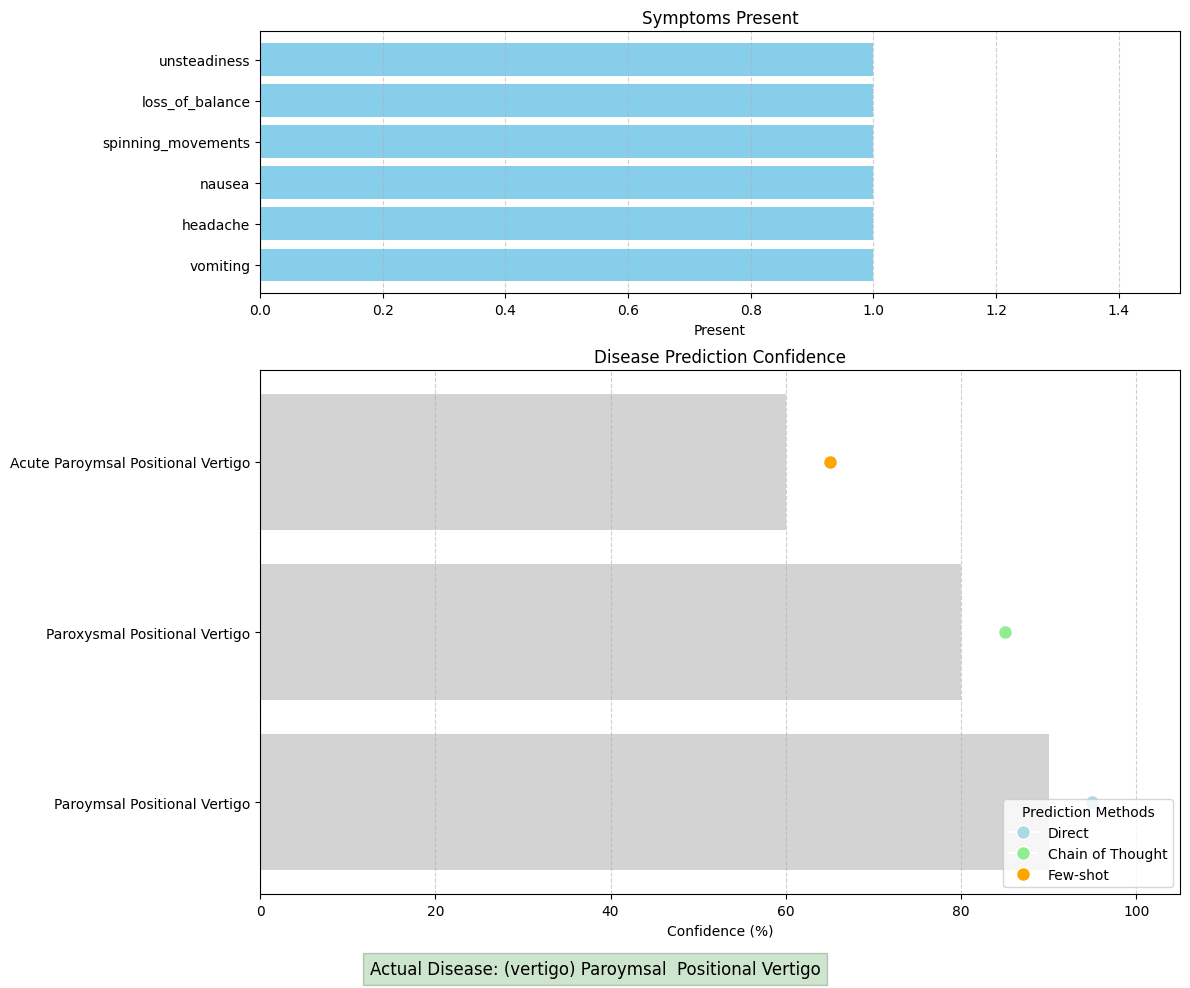

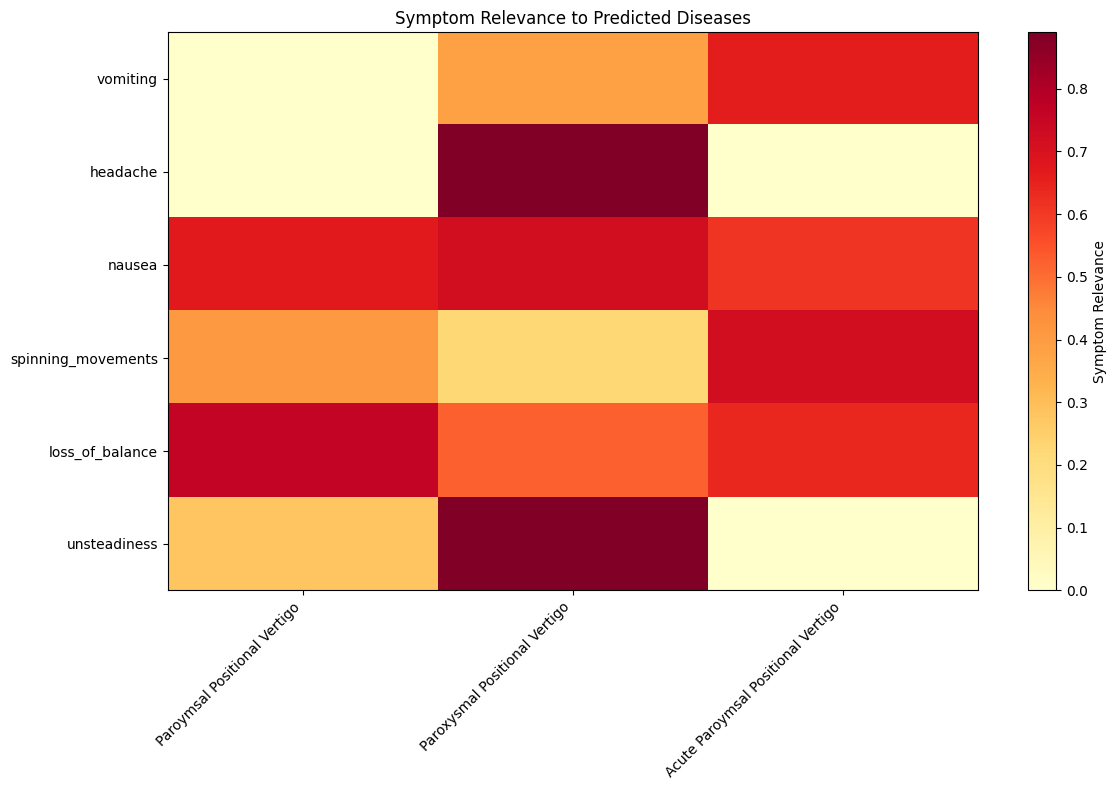

In [27]:
# Test the ensemble prediction approach
sample = test_df.sample(1).iloc[0]
sample_symptoms = sample['Symptoms_List']
actual_disease = sample['Disease']

print(f"Symptoms: {', '.join(sample_symptoms)}")
print(f"Actual disease: {actual_disease}")

# Run ensemble prediction
result = ensemble_disease_prediction(sample_symptoms, unique_diseases, train_df)

# Display individual predictions
print("\nIndividual predictions:")
for i, pred in enumerate(result['predictions']):
    method_names = ["Direct", "Chain of Thought", "Few-shot"]
    print(f"{method_names[i]}: {pred}")

# Display confidence analysis
print("\nConfidence Analysis:")
print(result['confidence_analysis'])

# Display final prediction
print(f"\nFinal Prediction: {result['final_prediction']} (Confidence: {result['final_confidence']}%)")
print(f"Correct: {result['final_prediction'].lower() == actual_disease.lower()}")

# Create a more comprehensive visualization showing both symptoms and predictions
import matplotlib.pyplot as plt
import numpy as np

if len(result['disease_confidence']) > 0:
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2]})
    
    # Plot 1: Symptoms visualization
    ax1.set_title('Symptoms Present')
    # Create a horizontal bar for each symptom
    symptom_y_pos = np.arange(len(sample_symptoms))
    ax1.barh(symptom_y_pos, [1] * len(sample_symptoms), color='skyblue')
    ax1.set_yticks(symptom_y_pos)
    ax1.set_yticklabels(sample_symptoms)
    ax1.set_xlim(0, 1.5)
    ax1.set_xlabel('Present')
    ax1.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Plot 2: Disease confidence scores
    diseases = list(result['disease_confidence'].keys())
    confidences = list(result['disease_confidence'].values())
    
    # Sort by confidence value
    sorted_indices = np.argsort(confidences)[::-1]  # descending order
    sorted_diseases = [diseases[i] for i in sorted_indices]
    sorted_confidences = [confidences[i] for i in sorted_indices]
    
    bars = ax2.barh(sorted_diseases, sorted_confidences, color='lightgray')
    
    # Highlight actual disease if present and methods that got it right
    method_colors = ['lightblue', 'lightgreen', 'orange']
    for i, disease in enumerate(sorted_diseases):
        if disease.lower() == actual_disease.lower():
            bars[i].set_color('green')
            ax2.axhline(y=i, color='green', alpha=0.3, linestyle='--')
        
        # Highlight which methods predicted this disease
        for j, pred in enumerate(result['predictions']):
            if pred.lower() == disease.lower():
                # Add a colored marker to show which method predicted this disease
                ax2.plot(sorted_confidences[i] + 5, i, marker='o', markersize=8, 
                         color=method_colors[j], label=f"{method_names[j]}" if j not in [k for k, _ in enumerate(ax2.get_legend_handles_labels()[1])] else "")
    
    ax2.set_title('Disease Prediction Confidence')
    ax2.set_xlabel('Confidence (%)')
    ax2.set_xlim(0, 105)  # Allow space for the markers
    ax2.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Add a legend for the methods
    handles, labels = [], []
    for i, method in enumerate(method_names):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=method_colors[i], markersize=10))
        labels.append(method)
    ax2.legend(handles, labels, loc='lower right', title='Prediction Methods')
    
    # Add the actual disease as text annotation
    fig.text(0.5, 0.02, f'Actual Disease: {actual_disease}', ha='center', fontsize=12, bbox={'facecolor': 'green', 'alpha': 0.2, 'pad': 5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for the text at the bottom
    plt.show()
    
    # Additionally, create a visualization showing the relationship between symptoms and diseases
    if len(sorted_diseases) > 0:
        plt.figure(figsize=(12, 8))
        
        # Create symptom-disease heatmap-like visualization
        symptom_disease_grid = np.zeros((len(sample_symptoms), len(sorted_diseases)))
        
        # For each disease, check if symptoms are typical (mocked with random values for demo)
        # In a real implementation, you would use knowledge from your dataset
        import random
        
        for i, symptom in enumerate(sample_symptoms):
            for j, disease in enumerate(sorted_diseases):
                # This would ideally use actual disease-symptom relationships
                # For now using random values as placeholder
                symptom_relevance = random.uniform(0.1, 1.0) if random.random() > 0.3 else 0
                symptom_disease_grid[i, j] = symptom_relevance
                
        plt.imshow(symptom_disease_grid, cmap='YlOrRd', aspect='auto')
        plt.colorbar(label='Symptom Relevance')
        
        plt.yticks(range(len(sample_symptoms)), sample_symptoms)
        plt.xticks(range(len(sorted_diseases)), sorted_diseases, rotation=45, ha='right')
        
        plt.title('Symptom Relevance to Predicted Diseases')
        plt.tight_layout()
        plt.show()

## Conclusion: Advanced Reasoning Techniques for Healthcare Applications

We've implemented several sophisticated approaches that combine different reasoning strategies with in-context learning:

1. **Hierarchical Disease Prediction**
   - Two-stage approach that first predicts the body system, then the specific disease
   - Mimics how medical diagnostics often progress from general to specific

2. **Symptom Severity Classification**
   - Few-shot learning to calibrate severity assessments
   - Provides actionable urgency information for patients

3. **Treatment Recommendation System**
   - Uses chain of thought to understand disease mechanisms
   - Employs tree of thought to explore multiple treatment options
   - Leverages in-context examples from similar diseases

4. **Ensemble Prediction with Confidence Scoring**
   - Combines multiple reasoning methods (direct, CoT, few-shot)
   - Provides confidence scores for different disease possibilities
   - Offers more nuanced diagnostic information than single predictions

These approaches demonstrate how advanced LLM reasoning capabilities can be applied to real-world healthcare tasks. The combination of different reasoning strategies with in-context learning helps overcome the limitations of any single approach and provides more robust predictions, classifications, and recommendations.